# Creating and benchmarking gene representations using Granite
The third generation of [Granite AI language models](https://www.ibm.com/granite) can deliver exceptional performance across a wide range of enterprise tasks, and Gene-Benchmarks is a package to benchmark pre-trained models on downstream gene-related tasks. In this notebook we will use the Granite models to create gene embeddings and then use the Gene-Benchmark package by doing do the following:
1.	Extract gene embeddings from the granite model
2.	Evaluate the quality of the embedding on a prediction task.
Together, this will give us a comprehensive picture of how well the Granite model can “understand” the properties of genes.
Let’s start by setting up the environment: 

In [1]:
import os
import warnings

from IPython.display import display
from PIL import Image

warnings.filterwarnings("ignore")
import pandas as pd

from gene_benchmark.descriptor import NCBIDescriptor
from gene_benchmark.encoder import SentenceTransformerEncoder
from gene_benchmark.tasks import EntitiesTask, load_task_definition

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### What is a task in gene-benchmark

The gene-benchmark package includes 293 gene-related tasks testing the ability to predict various properties. Each task is defined by a set of entities (gene symbols) and their corresponding properties (outcomes). For this notebook we use an example of a task called "bivalent vs non-methylated", which includes a set of genes and an indication of whether they are bivalent or non-methylated.(see further details in this [manuscript](https://arxiv.org/pdf/2412.04075)).  
Here’s a quick example of how to look at the definitions of the task:

In [ ]:
task = load_task_definition("bivalent vs non-methylated",tasks_folder="../tasks")
pd.concat([task.entities,task.outcomes],axis=1).head()

,symbol,Outcomes
0,HOXA11,bivalent
1,PAX6,bivalent
2,ZIC2,bivalent
3,COASY,bivalent
4,PAX2,bivalent


## 1. Extract gene embeddings from the granite model
The question of gene embeddings from a text model is complex. We could potentially just give the model the name of the gene and extract the embeddings. However, in our experience this provides very poor performance since the name is usually some arbitrary abbreviation of the gene description (for example, the gene BRCA1 is shorthand for “Breast Cancer Type 1 Susceptibility Protein”). We therefore opted to provide the text models with a more comprehensive description of the gene.
The Gene-Benchmark package provides easy functions to extract the gene description from the NCBI website, resulting in a csv file holding the required descriptions.


In [ ]:
description_builder=NCBIDescriptor()
descriptions = description_builder.describe(task.entities)
descriptions.head()

The package also provides a wrapper function that gives the gene description as input to the language model and then extract the embeddings. This function works for any text model that following the HuggingFace [SentenceTransformer](https://sbert.net/) API, here we will use the [granite embedding model](https://huggingface.co/ibm-granite/granite-embedding-125m-english)

In [ ]:
granite_model = "ibm-granite/granite-embedding-125m-english"
granite_embedding = SentenceTransformerEncoder(granite_model)
encodings = granite_embedding.encode(descriptions)

## 2. Evaluate the quality of the embedding on a prediction task.
Now that we have the embeddings, we can estimate their utility for the task. Gene-benchmark provide k-fold cross validation of the prediction task to evaluate the performance and standard deviation.

In [4]:
task = EntitiesTask(
    task="bivalent vs non-methylated",
    description_builder=NCBIDescriptor(),
    encoder=SentenceTransformerEncoder(granite_model),
    tasks_folder="../tasks"
)
_ = task.run()
print(f" mean AUC: {task.summary()['mean_roc_auc']:.2f} sd: {task.summary()['sd_roc_auc']:.2f}")

Batches: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


 mean AUC: 0.90 sd: 0.08


## Bonus: evaluating multiple encodings and multiple tasks
We showed an example of how to create the embeddings for a specific task. Batch evaluation of multiple tasks and models it can be done using the `run_task.py` script, which outputs the performance into a CSV file. This requires defining a YAML file for each model, defining the name of the model, the task list, etc. For example, the three YAML files in [this folder](./granite_files) allow running evaluations of 3 versions of granite on two tasks available in Gene-Benchmarks using the following command line:

`python run_task.py -t "Gene2Gene" -t "long vs short range TF"  -m granite_files/granite8b.yaml -m granite_files/granite2b.yaml -m granite_files/graniteEmbed.yaml --output-file-name /performance/bin.csv`  

If you want to run the models on more tasks you can use the task list file in [this folder](../scripts/task_configs)

We used the script to compare the performance on 293 tasks of three models - [Granite8B](https://huggingface.co/ibm-granite/granite-3.1-8b-base), [Granite2B](https://huggingface.co/ibm-granite/granite-3.1-2b-base) and [Granite embedding model](https://huggingface.co/ibm-granite/granite-embedding-125m-english). The overall results are presented as a heatmap. we can see that the embeddings model might be very small but it is comparable in performance to the larger general LLM models. 

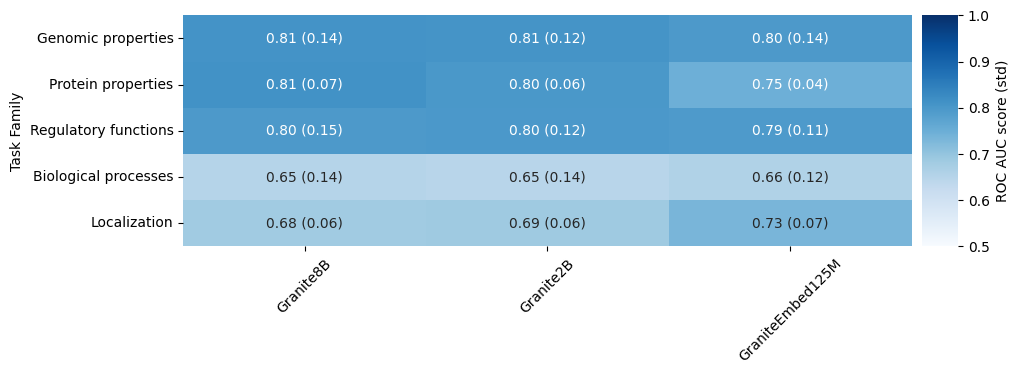

In [5]:
image = Image.open("./granite_files/overall.png")
display(image)

We can have a more finegrained understanding by looking at each task:

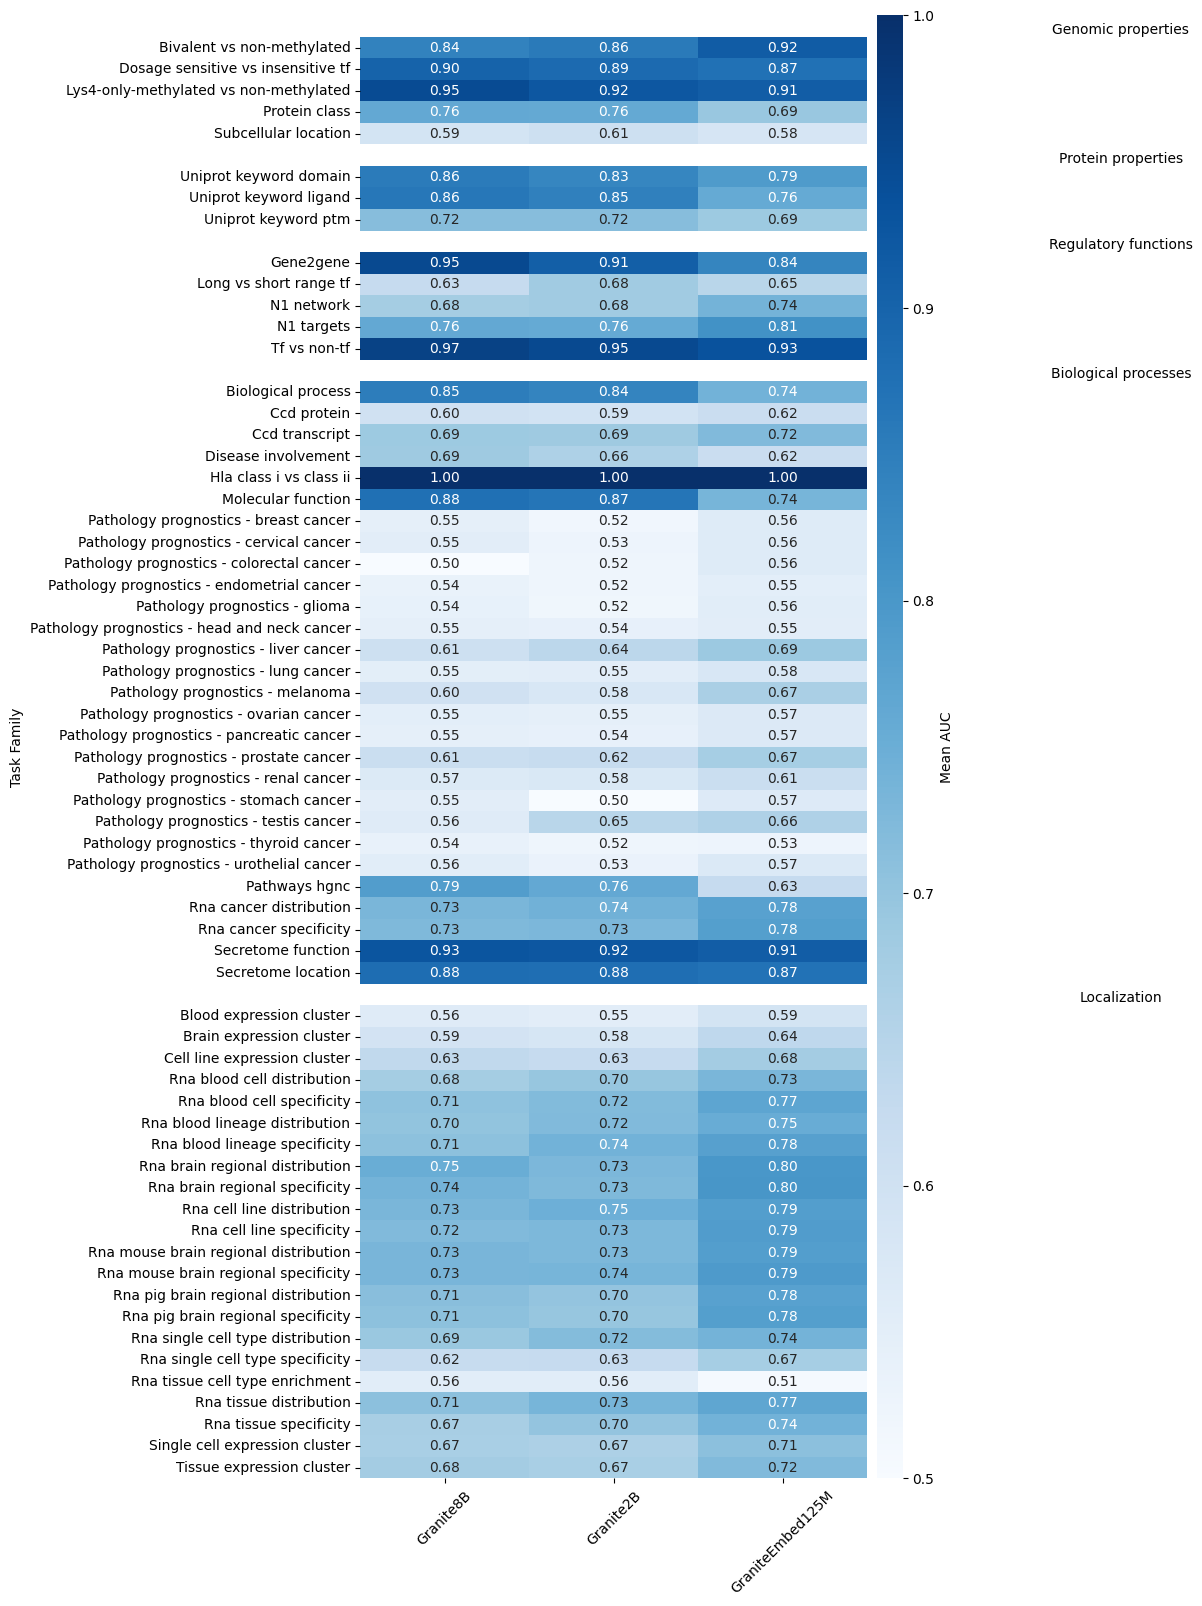

In [6]:
image = Image.open("./granite_files/long.png")
display(image)

For additional details see our manuscript [Does your model understand genes? A benchmark of gene properties for biological and text models
](https://arxiv.org/abs/2412.04075).